In [79]:
!pip install torch
!pip install matplotlib


You should consider upgrading via the 'c:\users\adam\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\adam\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [106]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import torch
import numpy as np
img_dir = "C:/Users/Adam/Downloads/UF_Spring_2022/Deep_Learning/Proj2/face_images/"
torch.set_default_tensor_type('torch.FloatTensor')

In [130]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [131]:
data = load_images_from_folder(img_dir)

In [137]:
print(data[0].shape) #each images is 128 by 128 pixels and in rgb thus the 3 for color values
print(len(data)) #number of images in dataset
print(type(data))
print(type(data[0]))

torch.Size([3, 128, 128])
750
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [143]:
data = np.asarray(data)
print(data.shape)

(750, 128, 128, 3)


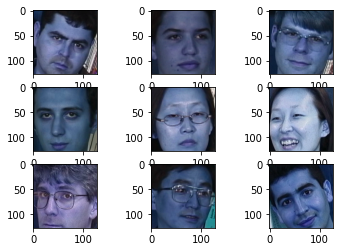

In [134]:
for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[i][:,:,:])

Now we will convert how the images are stored and augment them to get more data 

In [144]:
data = torch.from_numpy(data) #converts numpy matrix to tensor
data = torch.movedim(data, 3, 1) #moves the rgb to the second index
data = data[torch.randperm(data.size()[0])] #randomly shuffles tensor along first dim 

In [145]:
print(data.shape)
print(type(data))

torch.Size([750, 3, 128, 128])
<class 'torch.Tensor'>


In [149]:
def print_tensor_to_numpy(tensor, image_pos):
    npimg = tensor[image_pos, :, :, :].np()
    cv2.imshow(npimg)
    

In [150]:
print_tensor_to_numpy(data, 0)

AttributeError: 'Tensor' object has no attribute 'np'